In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
extracted_folder = "/Users/vishvatejaguduguntla/Downloads/Cancer_detection/skin_cancer_images"
classes = os.listdir(extracted_folder)
print(os.listdir(extracted_folder))
     

['.DS_Store', 'Test', 'Train']


In [3]:
train_fold = "/Users/vishvatejaguduguntla/Downloads/Cancer_detection/skin_cancer_images/Train"
classes = os.listdir(train_fold)
print(os.listdir(train_fold))

['.DS_Store', 'melanoma', 'pigmented benign keratosis', 'nevus', 'basal cell carcinoma', 'actinic keratosis', 'squamous cell carcinoma', 'vascular lesion', 'seborrheic keratosis', 'dermatofibroma']


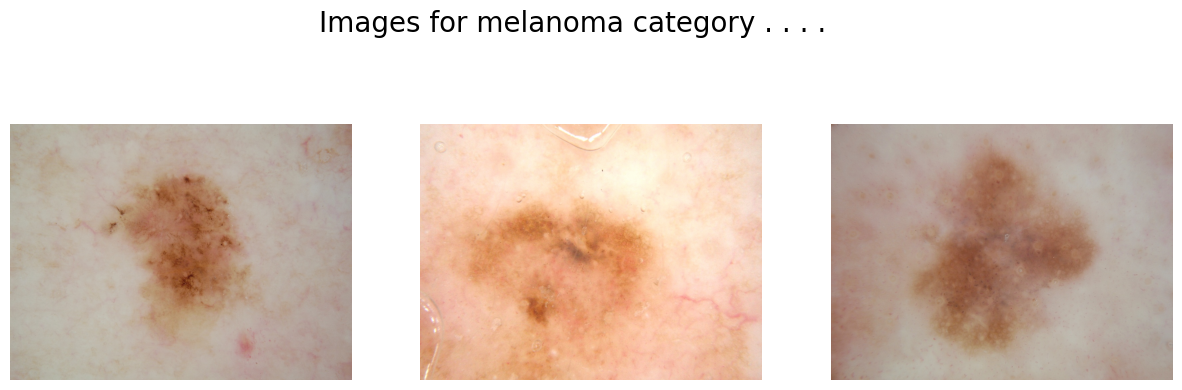

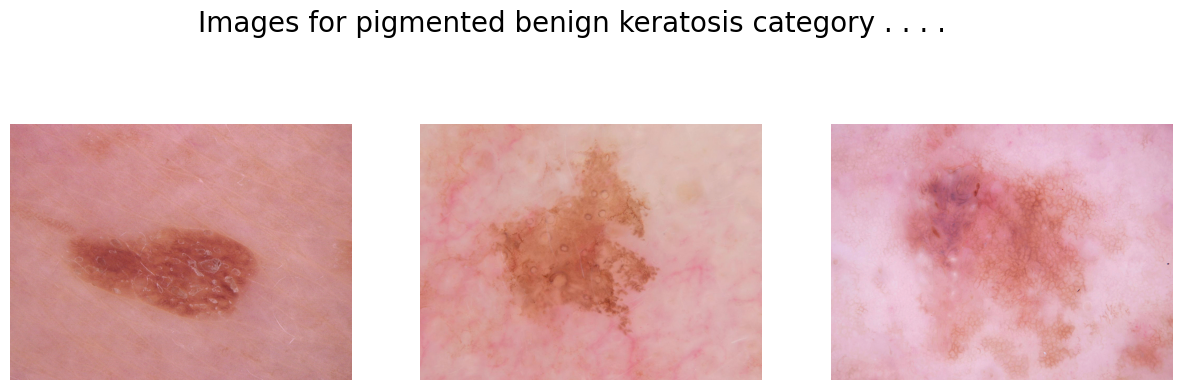

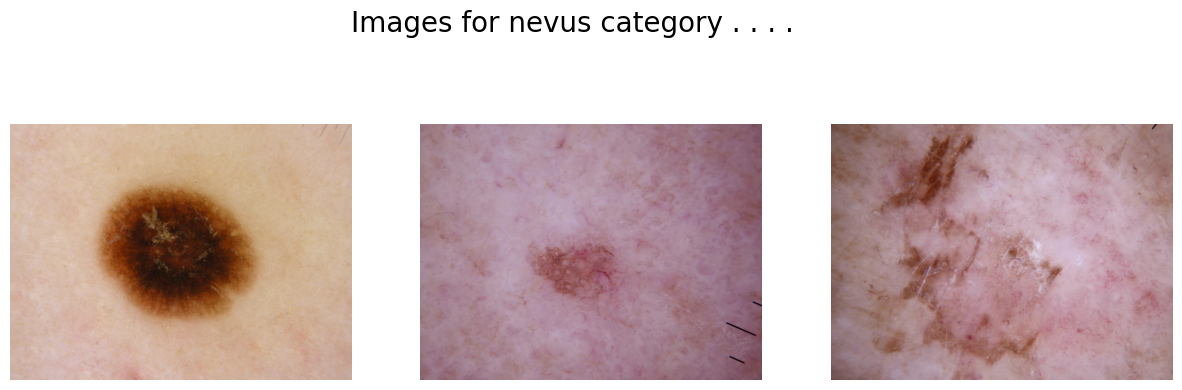

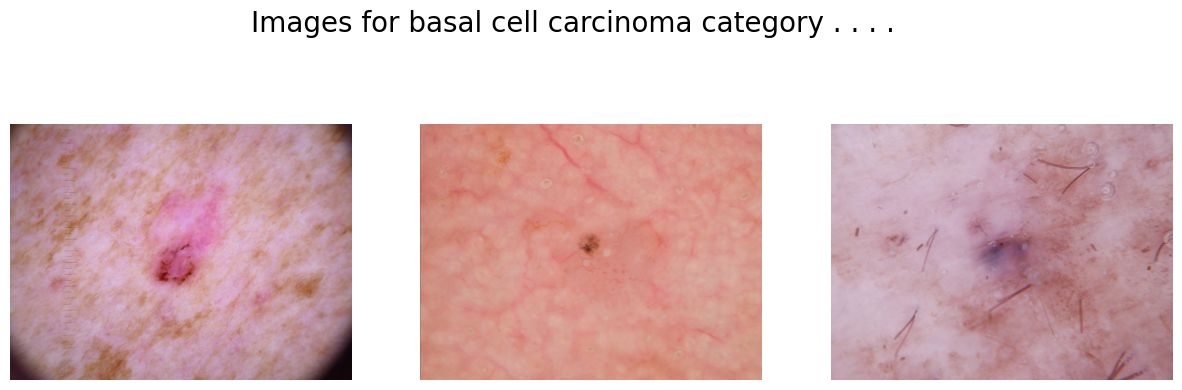

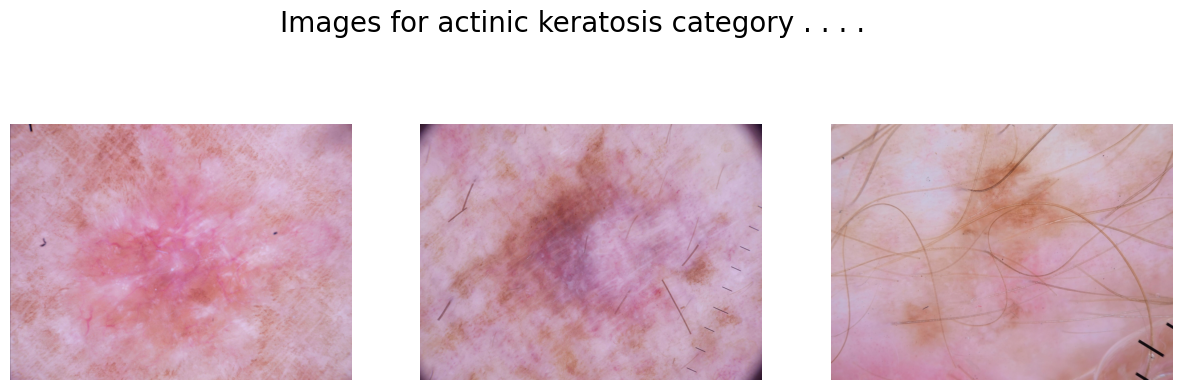

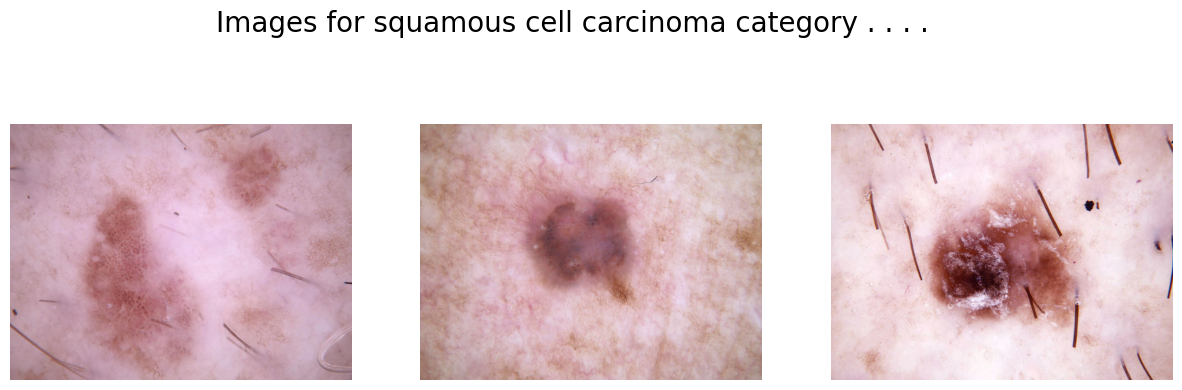

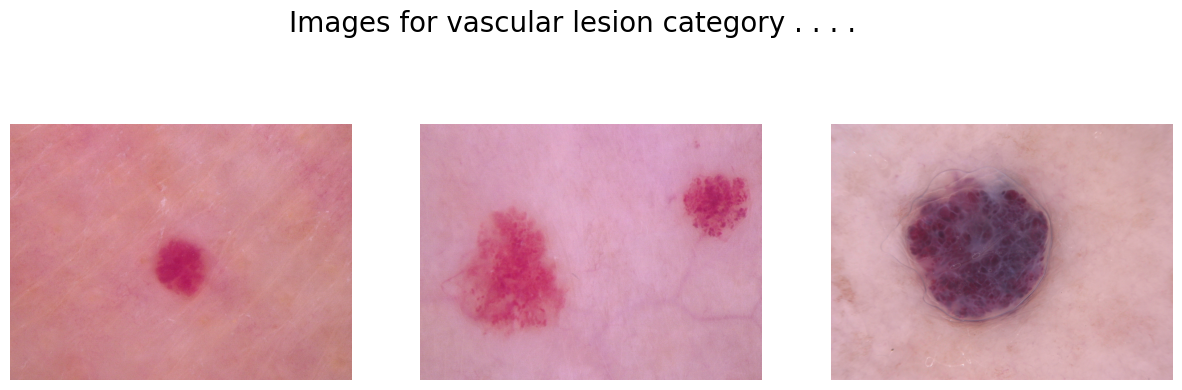

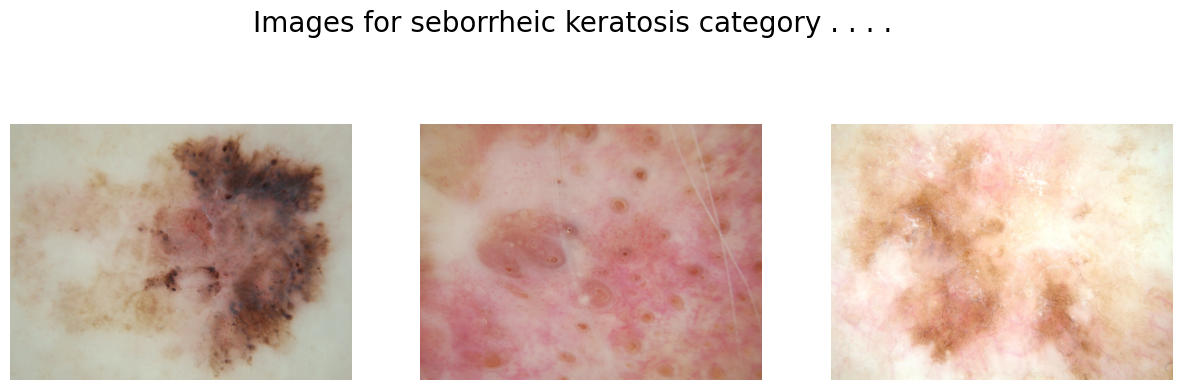

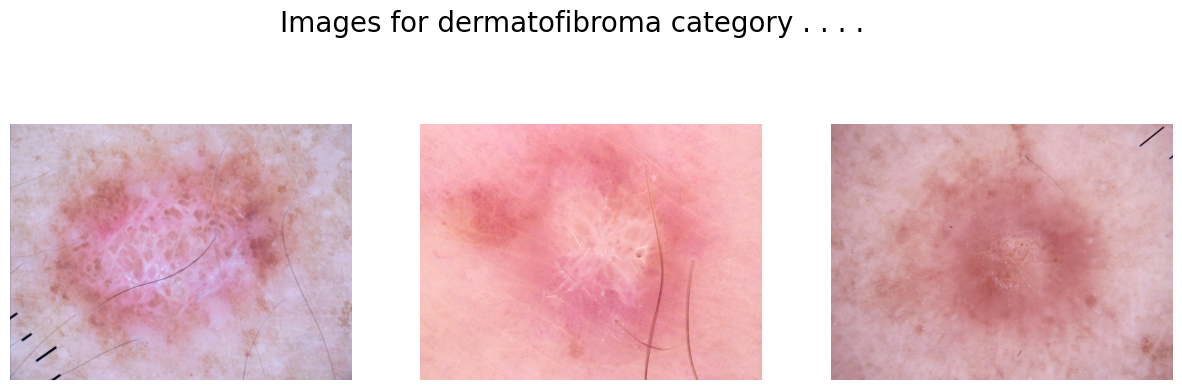

In [4]:
for cat in classes:
    if cat != ".DS_Store":
        image_dir = f'{train_fold}/{cat}'
        images = os.listdir(image_dir)
        images = [img for img in images if os.path.isfile(os.path.join(image_dir, img))]

        fig, ax = plt.subplots(1, 3, figsize = (15, 5))
        fig.suptitle(f'Images for {cat} category . . . .',
                     fontsize = 20)

        for i in range(3):
            if images:
                k = np.random.randint(0, len(images))
                img = np.array(Image.open(f'{train_fold}/{cat}/{images[k]}'))
                ax[i].imshow(img)
                ax[i].axis('off')
            else:
                print(f"No images found in directory: {image_dir}")
        plt.show()

In [5]:
train_folder = "/Users/vishvatejaguduguntla/Downloads/Cancer_detection/skin_cancer_images/Train"
test_folder = "/Users/vishvatejaguduguntla/Downloads/Cancer_detection/skin_cancer_images/Test"

IMG_SIZE = 224

X_train, Y_train = [], []
X_test, Y_test = [], []


In [6]:
for i, cat in enumerate(classes):
    images = glob(f"{train_folder}/{cat}/*.jpg")
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X_train.append(img)
            Y_train.append(i)
        else:
            print(f"Failed to load image: {image}")

In [7]:

for i, cat in enumerate(classes):
    images = glob(f"{test_folder}/{cat}/*.jpg")
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X_test.append(img)
            Y_test.append(i)
        else:
            print(f"Failed to load image: {image}")


In [8]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2239, 224, 224, 3)
(118, 224, 224, 3)
(2239,)
(118,)


In [10]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Y_train = np.array(Y_train) - 1
Y_test = np.array(Y_test) - 1

Y_train = to_categorical(Y_train, num_classes=9)
Y_test = to_categorical(Y_test, num_classes=9)


print(Y_train.shape) 
print(Y_test.shape)  


(2239, 9)
(118, 9)


In [11]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(9, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 263,433 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# with datagen dude to low accuracy

In [16]:
from keras.models import Sequential
import keras.models
from keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

input_shape = (224,224,3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(9, activation='softmax'))
model.summary()

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,963,433 (49.45 MB)

 Trainable params: 12,963,433 (49.45 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=1,
    batch_size=16,
    verbose=1
)


Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.1871 - loss: 2.1528 - val_accuracy: 0.1356 - val_loss: 2.2230
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.2005 - loss: 2.0352 - val_accuracy: 0.1525 - val_loss: 2.5693
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3746s 27s/step - accuracy: 0.2541 - loss: 1.9709 - val_accuracy: 0.1610 - val_loss: 2.3006
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.2473 - loss: 1.9618 - val_accuracy: 0.1525 - val_loss: 2.4151
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.2501 - loss: 1.9460 - val_accuracy: 0.1525 - val_loss: 2.5984
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.2307 - loss: 1.9655 - val_accuracy: 0.1525 - val_loss: 3.1529
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2429 - loss: 1.9527 - val_accuracy: 0.1525 - val_loss: 2.3765
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.2627 - loss: 1.9324 - val_ac

In [ ]:
print("X_train:", type(X_train), "shape:", getattr(X_train, "shape", None))
print("Y_train:", type(Y_train), "shape:", getattr(Y_train, "shape", None))
print("X_test:", type(X_test), "shape:", getattr(X_test, "shape", None))
print("Y_test:", type(Y_test), "shape:", getattr(Y_test, "shape", None))


In [18]:
!git init

Initialized empty Git repository in /Users/vishvatejaguduguntla/cancer detction/skin model /.git/


In [19]:
!git config --global user.name "vishva2410"
!git config --global user.email "vishvateja10@gmail.com"

In [20]:
!git remote add origin https://github.com/vishva2410/Deep-Learning-Projects-Part-A-.git


In [22]:
model.save("resnet_skin_cancer_model.h5")


In [23]:
!git add resnet_skin_cancer_model.h5
!git commit -m "Add trained ResNet model for skin cancer detection"


[main (root-commit) 35b2fb3] Add trained ResNet model for skin cancer detection
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 resnet_skin_cancer_model.h5


!git push https://ghp_YourTokenHere@github.com/vishva2410/Deep-Learning-Projects-Part-A-.git main
